In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.decomposition import PCA

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/pradip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pradip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
file = open('Frankenstein.txt', 'r')

# Store data of the txt file in a list
doc = list(map(lambda x: x, file))

# Convert list to string
data = ""
for i in doc:
  data = ' '. join(doc) 

# replace unnecessary stuff with space
# new line, carriage return, unicode character --> replace by space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')\
            .replace('“','').replace('”','')  
     

In [4]:
# remove unnecessary spaces 
split_data = data.split()
corpus = ' '.join(split_data)
print(f'Sample words in corpus:\n\t{corpus[:102]}')
print(f'Total number of words is {len(corpus)}')

Sample words in corpus:
	The Project Gutenberg eBook of Frankenstein, by Mary Wollstonecraft (Godwin) Shelley This eBook is for
Total number of words is 436916


In [5]:
def extract_unique_words(text):
    # Lowercase and tokenize the text
    text = text.lower()
    tokenizer = RegexpTokenizer(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    words = tokenizer.tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Count the number of words and unique words
    print("# of words in the text: ", len(words))

    unique_words = sorted(set(words))
    print("# of unqiue words in the text: ", len(unique_words))

    return unique_words

unique_words = extract_unique_words(corpus)

# of words in the text:  78355
# of unqiue words in the text:  7248


In [6]:
def generate_cbows(text, window_size):
    # Lowercase and tokenize the text
    text = text.lower()
    tokenizer = RegexpTokenizer(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    words = tokenizer.tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Create CBOW pairs with a given window size
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

# Create cbows
cbows = generate_cbows(corpus, window_size=3)

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Context Words: {context_words}, Target Word: {target_word}')

Context Words: ['project', 'gutenberg', 'ebook', 'mary', 'wollstonecraft', 'godwin'], Target Word: frankenstein
Context Words: ['gutenberg', 'ebook', 'frankenstein', 'wollstonecraft', 'godwin', 'shelley'], Target Word: mary
Context Words: ['ebook', 'frankenstein', 'mary', 'godwin', 'shelley', 'ebook'], Target Word: wollstonecraft


In [7]:
def one_hot_encoding(word, unique_words):
    encoding = [1 if word == w else 0 for w in unique_words]
    return torch.tensor(encoding, dtype=torch.float32)

def cbow_one_hot_vector_pair(unique_words, cbows):
    one_hot_encodings = dict(map(lambda x: (x, one_hot_encoding(x, unique_words)), unique_words))
    cbow_vector_pairs = [([one_hot_encodings[word] for word in context_words],
                          one_hot_encodings[target_word]) for context_words, target_word in cbows]
    cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors,
                         target_vector in cbow_vector_pairs]
    return cbow_vector_pairs

In [8]:
cbow_vector_pairs = cbow_one_hot_vector_pair(unique_words, cbows)

In [9]:
class get_data(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample, output_sample

In [10]:
class word2vec(nn.Module):
    def __init__(self, VOCAB_SIZE, VEC_DIM, EPOCHES, learning_rate, batch_size, split_index, verbose=False) -> None:
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vec_dim = VEC_DIM
        self.epochs = EPOCHES
        self.lr = learning_rate
        self.verbose = verbose
        self.split_index = split_index
        self.batch_size = batch_size
        self.W1 = nn.Parameter(data=torch.empty(self.vocab_size, self.vec_dim), requires_grad=True) # Word vector
        torch.nn.init.kaiming_normal_(self.W1, mode='fan_in', nonlinearity='relu')
        self.W2 = nn.Parameter(data=torch.empty(self.vec_dim, self.vocab_size), requires_grad=True)
        torch.nn.init.kaiming_normal_(self.W2, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = torch.tanh(X)
        X = X @ self.W2

        return torch.sigmoid(X)

    def fit(self, data):
        train_dataset = get_data(data[:self.split_index])
        val_dataset = get_data(data[self.split_index:])

        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        validation_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

        train_set_loss_log = []
        validation_set_loss_log = []

        min_loss = np.inf
        best_w = None

        for epoch in range(self.epochs):
            self.train()
            total_train_loss = 0.0
            num_train_batches = 0 

            for inputs_batch, outputs_batch in train_dataloader:
                y_train_logits = self.forward(inputs_batch)
                train_loss = loss_fn(y_train_logits, outputs_batch)
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

                total_train_loss += train_loss.item()
                num_train_batches += 1

            avg_train_loss = total_train_loss/num_train_batches
            train_set_loss_log.append(avg_train_loss)


            self.eval()
            total_val_loss = 0.0
            num_validation_batches = 0
            with torch.inference_mode():
                for inputs_batch, outputs_batch in validation_dataloader:
                    y_val_logits = self.forward(inputs_batch)
                    val_loss = loss_fn(y_val_logits, outputs_batch)

                    total_val_loss += val_loss.item()
                    num_validation_batches += 1
            avg_val_loss = total_val_loss / num_validation_batches
            validation_set_loss_log.append(avg_val_loss)

            if self.verbose: 
                print(f'Epoch {epoch}: Train Loss: {avg_train_loss} ||| Validation Loss: {avg_val_loss}')
            
            if avg_val_loss < min_loss:
                min_loss = avg_val_loss
                best_w = self.state_dict()

        return best_w, train_set_loss_log, validation_set_loss_log


In [11]:
model = word2vec(VOCAB_SIZE=len(unique_words), VEC_DIM=2,
                 EPOCHES=20, learning_rate=0.01, batch_size=64,
                 split_index=int(len(cbow_vector_pairs) * 0.90), verbose=True)

In [12]:
best_model, train, val = model.fit(cbow_vector_pairs)

Epoch 0: Train Loss: 8.75554807856679 ||| Validation Loss: 8.760106237311112
Epoch 1: Train Loss: 8.565347917377949 ||| Validation Loss: 8.717506140993352
Epoch 2: Train Loss: 8.513410571962595 ||| Validation Loss: 8.705106885809647
Epoch 3: Train Loss: 8.490209562703967 ||| Validation Loss: 8.700260530438339
Epoch 4: Train Loss: 8.476230787113309 ||| Validation Loss: 8.69697654456423
Epoch 5: Train Loss: 8.46631127409637 ||| Validation Loss: 8.695429417124966
Epoch 6: Train Loss: 8.458498161286116 ||| Validation Loss: 8.694068574068838
Epoch 7: Train Loss: 8.452313283458352 ||| Validation Loss: 8.69139768366228
Epoch 8: Train Loss: 8.446911221370101 ||| Validation Loss: 8.691225921898557
Epoch 9: Train Loss: 8.44254593923688 ||| Validation Loss: 8.690885543823242
Epoch 10: Train Loss: 8.43844722956419 ||| Validation Loss: 8.69149611289041
Epoch 11: Train Loss: 8.434452343732119 ||| Validation Loss: 8.69233032695034
Epoch 12: Train Loss: 8.431272074580193 ||| Validation Loss: 8.6920634

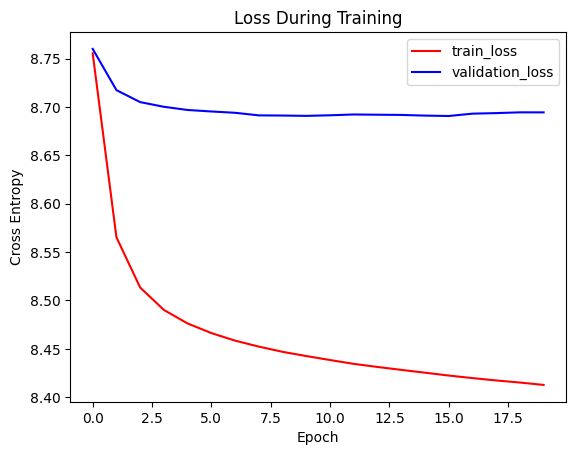

In [13]:
plt.plot(train, color='red', label='train_loss')
plt.plot(val, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [14]:
def word_embedding(best_model, unique_words):
    word_vector = list(best_model.get('W1'))
    word_emb_dict = dict(map(lambda x: (x[0], x[1]), zip(unique_words, word_vector)))
    return word_emb_dict

In [15]:
word_emb_dict = word_embedding(best_model, unique_words)

In [73]:
def cosine_similarity(x1, x2):
    return (x1 @ x2) / (torch.norm(x1) * torch.norm(x2))

def top_k_similaritys(*, word, word_emb_dict=word_emb_dict, k):
    similarity = dict(
        sorted(
            map(lambda x: (x, cosine_similarity(word_emb_dict[word], word_emb_dict[x]).item()), word_emb_dict),
            key=lambda item: item[1],
            reverse=True
        )
    )
    del similarity[word]
    return list(similarity.keys())[:k]

def reduce_dim_pca(*, best_model=best_model, component=2, data):
    pca = PCA(n_components=component)
    word_vector = best_model.get('W1').detach().numpy()
    pca.fit(word_vector)
    data_pca = pca.transform(data)
    return data_pca

In [90]:
def plot_vector(word, word_emb_dict=word_emb_dict, k=5):

    # Find top k similarities
    similarities = top_k_similaritys(word=word, k=k)
    print(f' Similar words of {word} is {similarities}')

    # Dimension reduction
    similarity_data = list(map(lambda x: word_emb_dict[x].detach().numpy(), similarities))
    similarity_data.append(word_emb_dict[word].detach().numpy())
    dimension_red = reduce_dim_pca(data=similarity_data)

    context = dimension_red[:k]
    target = dimension_red[k]

    # Origin for all vectors
    origin = [0], [0]  
    
    # Plot vectors for similar words
    for vec, name in zip(context, similarities):
        vec_x = vec[0]
        vec_y = vec[1]
        plt.quiver(origin[0], origin[1], [vec_x], [vec_y], color='b', angles='xy', scale_units='xy', scale=1)
        plt.text(vec_x, vec_y, name, fontsize=9, ha='center')  # Label similar vectors
    
    # Plot vector for the target word
    word_x = target[0]
    word_y = target[1]
    plt.quiver(origin[0], origin[1], [word_x], [word_y], color='r', angles='xy', scale_units='xy', scale=1)
    plt.text(word_x, word_y, word, fontsize=9, ha='center', color='red')  # Label target word vector
    
    # Auto-scaling limits based on vector magnitudes
    all_vectors = context + [target]
    max_x = max(list(map(lambda x: x[0], all_vectors)))
    max_y = max(list(map(lambda x: x[1], all_vectors)))

    min_x = min(list(map(lambda x: x[0], all_vectors)))
    min_y = min(list(map(lambda x: x[1], all_vectors)))

    plt.xlim(min(-1, min_x-1), max(max_x + 1, 5))  # Adjust the limit dynamically
    plt.ylim(min(-1, min_y-1), max(max_y + 1, 5)) 
    
    plt.grid()
    plt.show()


 Similar words of boy is ['earthquake', 'human', 'kinsman', 'erroneously', 'victorious']


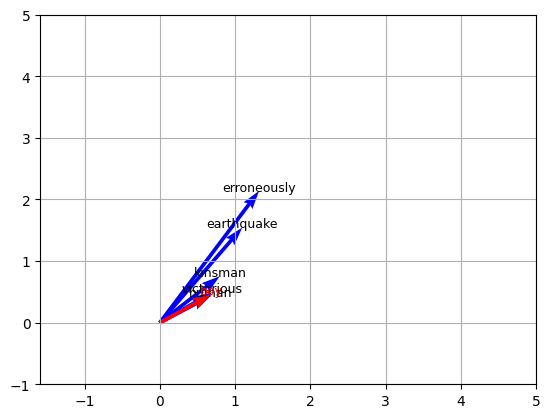

In [94]:
plot_vector('boy')

 Similar words of king is ['embraced', 'shudder', 'autumn', 'indirectly', 'strasburgh']


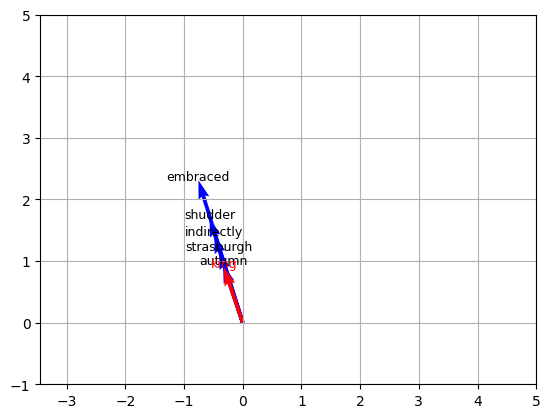

In [95]:
plot_vector('king')

 Similar words of queen is ['jeer', 'prayer', 'succour', 'hair', 'mechanics']


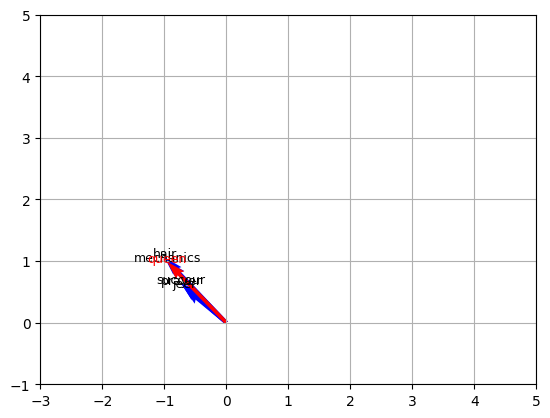

In [96]:
plot_vector('queen')

 Similar words of man is ['devouring', 'insufficient', 'closely', 'met', 'pang']


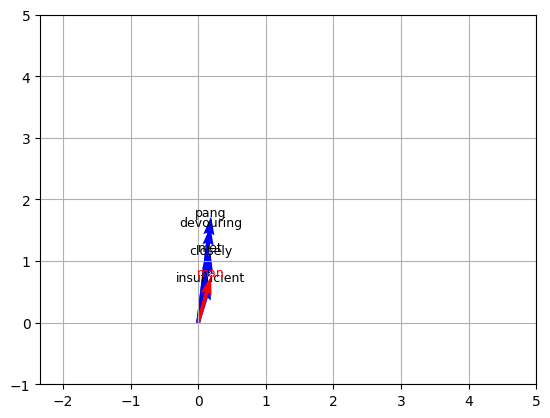

In [97]:
plot_vector('man')

 Similar words of woman is ['particularly', 'moment', 'laboratory', 'festival', 'paris']


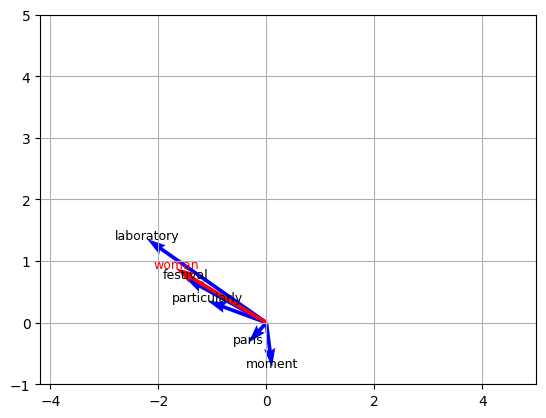

In [98]:
plot_vector('woman')

 Similar words of girl is ['passing', 'fancy', 'familiar', 'insultingly', 'principal']


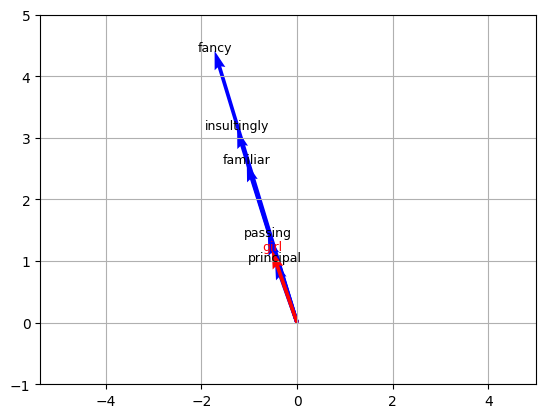

In [99]:
plot_vector('girl')